<a href="https://colab.research.google.com/github/AnastasiaBrinati/experiments/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **PROVA MODELLI CENTRALIZZATI PREDIZIONE INVOCATIONS' RATE**



#### Imports

In [243]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

!pip install -q -U keras-tuner
import keras_tuner as kt

# Use seaborn for pairplot.
!pip install datasets

from datasets import load_dataset

# Data

In [244]:
dataset_60 = load_dataset("anastasiafrosted/globus_60", download_mode="force_redownload")
dataset_300 = load_dataset("anastasiafrosted/globus_300", download_mode="force_redownload")
dataset_3600 = load_dataset("anastasiafrosted/globus_3600", download_mode="force_redownload")
dataset_86400 = load_dataset("anastasiafrosted/globus_86400", download_mode="force_redownload")

df_60 = pd.DataFrame(dataset_60['train'])
df_300 = pd.DataFrame(dataset_300['train'])
df_3600 = pd.DataFrame(dataset_3600['train'])
df_86400 = pd.DataFrame(dataset_86400['train'])

# Ensure the `timestamp` column is in datetime format
df_60['timestamp'] = pd.to_datetime(df_60['timestamp'])
df_300['timestamp'] = pd.to_datetime(df_300['timestamp'])
df_3600['timestamp'] = pd.to_datetime(df_3600['timestamp'])
df_86400['timestamp'] = pd.to_datetime(df_86400['timestamp'])

train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/176523 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/996k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/37667 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/173k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3553 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/178 [00:00<?, ? examples/s]

In [245]:
data = df_300
data = data.set_index("timestamp")
#data.head()

In [246]:
origin = "2023-06-15"
start = "2023-07-02" # origin + prediction_lenght
end = "2023-07-08"

train_data = data["2022-12-20":origin]
valid_data = data[origin:start]
test_data = data[start:]

#### Scaling

In [247]:
from sklearn.preprocessing import StandardScaler

# Crea un'istanza dello scaler
scaler = StandardScaler()

# Per il dataset di training
scaled_train = train_data.copy()
scaled_train[scaled_train.columns.drop('avg_invocations_rate')] = scaler.fit_transform(
    train_data[train_data.columns.drop('avg_invocations_rate')]
)
train = scaled_train

# Per il dataset di validazione
scaled_valid = valid_data.copy()
scaled_valid[scaled_valid.columns.drop('avg_invocations_rate')] = scaler.transform(
    valid_data[valid_data.columns.drop('avg_invocations_rate')]
)
valid = scaled_valid

# Per il dataset di test
scaled_test = test_data.copy()
scaled_test[scaled_test.columns.drop('avg_invocations_rate')] = scaler.transform(
    test_data[test_data.columns.drop('avg_invocations_rate')]
)
test = scaled_test

#### Config (Parameters)

In [248]:
batch_size = 32
num_features = 6
sequence_lenght = 7
prediction_lenght = 7

seed = 123
neurons = 32
epochs = 10

# Models

## Forecasting one-step-ahead

In [249]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate=0.01, epochs=epochs):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=10, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

### Univariate series

In [250]:
tr = train['avg_invocations_rate']
vl = valid['avg_invocations_rate']
ts = test['avg_invocations_rate'][:-1]

In [251]:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    tr.to_numpy(),
    targets=tr[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    vl.to_numpy(),
    targets=vl[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_ds = tf.keras.utils.timeseries_dataset_from_array(
    ts.to_numpy(),
    targets=ts[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Linear Model

In [252]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[sequence_lenght])
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [253]:
fit_and_evaluate(model, train_ds, valid_ds)

Epoch 1/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.0090 - mae: 0.0784 - val_loss: 0.0013 - val_mae: 0.0259
Epoch 2/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0019 - mae: 0.0313 - val_loss: 0.0011 - val_mae: 0.0235
Epoch 3/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.0017 - mae: 0.0291 - val_loss: 0.0010 - val_mae: 0.0226
Epoch 4/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 0.0015 - mae: 0.0276 - val_loss: 9.2537e-04 - val_mae: 0.0209
Epoch 5/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.0014 - mae: 0.0265 - val_loss: 8.6499e-04 - val_mae: 0.0207
Epoch 6/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0013 - mae: 0.0256 - val_loss: 8.1323e-04 - val_mae: 0.0199
Epoch 7/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0013 - mae: 0.0248 - val_loss: 7.7643e-04 - val_mae: 0.0199
Epoch 8/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0012 - mae: 0.0242 - val_loss: 7.4318e-04 - val_mae: 0.0194
Epoch 9/10

18494.661897420883

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


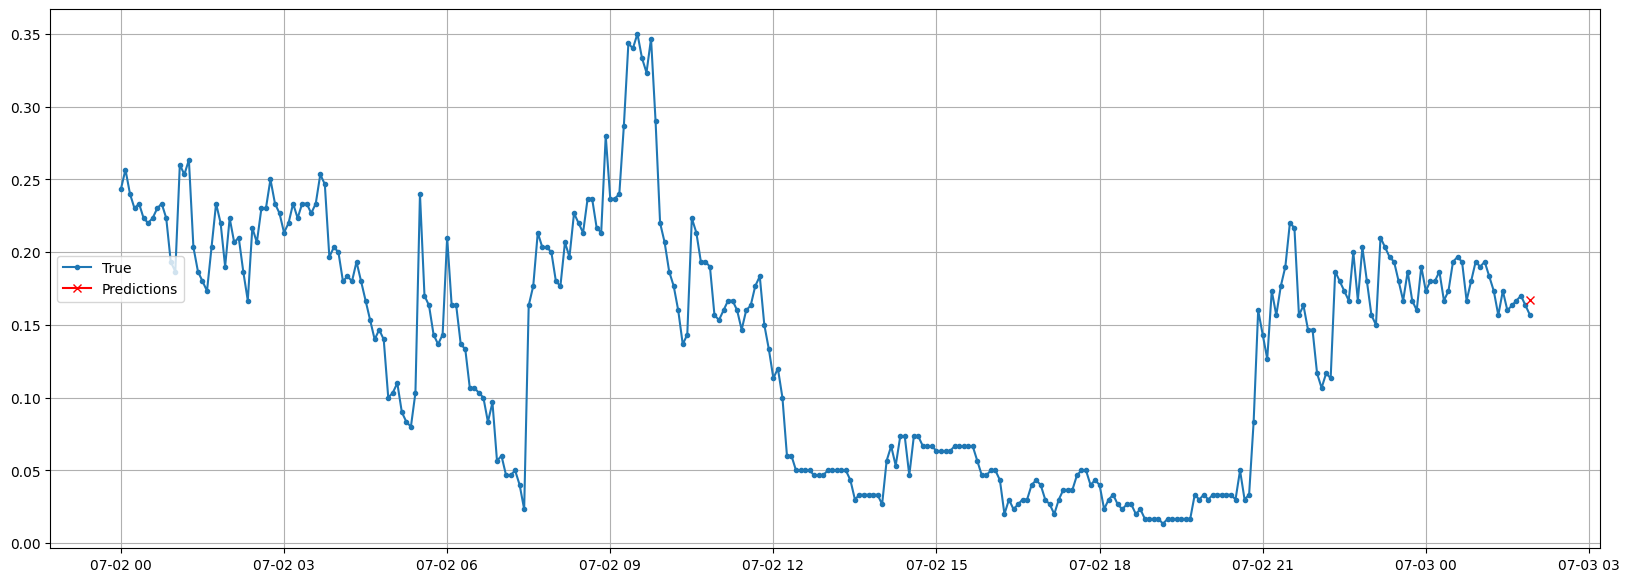

In [254]:
Y_pred = model.predict(test_ds)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test.index[-1], end=test.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

#### Simple RNN

Recall that the input_shape argument ignores
the first dimension (i.e., the batch size), and since recurrent layers can accept
input sequences of any length, we can set the second dimension to None, which
means “any size”. Lastly, since we’re dealing with a univariate time series, we
need the last dimension’s size to be 1. This is why we specified the input shape
* [None, 1] : it means “univariate sequences of any length”.


In [255]:
univar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons*2, input_shape=[None, 1]),
  tf.keras.layers.Dense(1) # no activation function by default
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [256]:
fit_and_evaluate(univar_model, train_ds, valid_ds)

Epoch 1/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0016 - mae: 0.0300 - val_loss: 6.3112e-04 - val_mae: 0.0170
Epoch 2/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0010 - mae: 0.0230 - val_loss: 6.0538e-04 - val_mae: 0.0162
Epoch 3/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0010 - mae: 0.0223 - val_loss: 5.8162e-04 - val_mae: 0.0162
Epoch 4/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0010 - mae: 0.0221 - val_loss: 5.7625e-04 - val_mae: 0.0156
Epoch 5/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 9.9259e-04 - mae: 0.0219 - val_loss: 5.7608e-04 - val_mae: 0.0166
Epoch 6/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 9.9922e-04 - mae: 0.0220 - val_loss: 5.8184e-04 - val_mae: 0.0178
Epoch 7/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0010 - mae: 0.0221 - val_loss: 5.7832e-04 - val_mae: 0.0170
Epoch 8/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 9.9277e-04 - mae: 0.0218 - val_loss: 5.8785e-04 - val

15550.88721215725

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


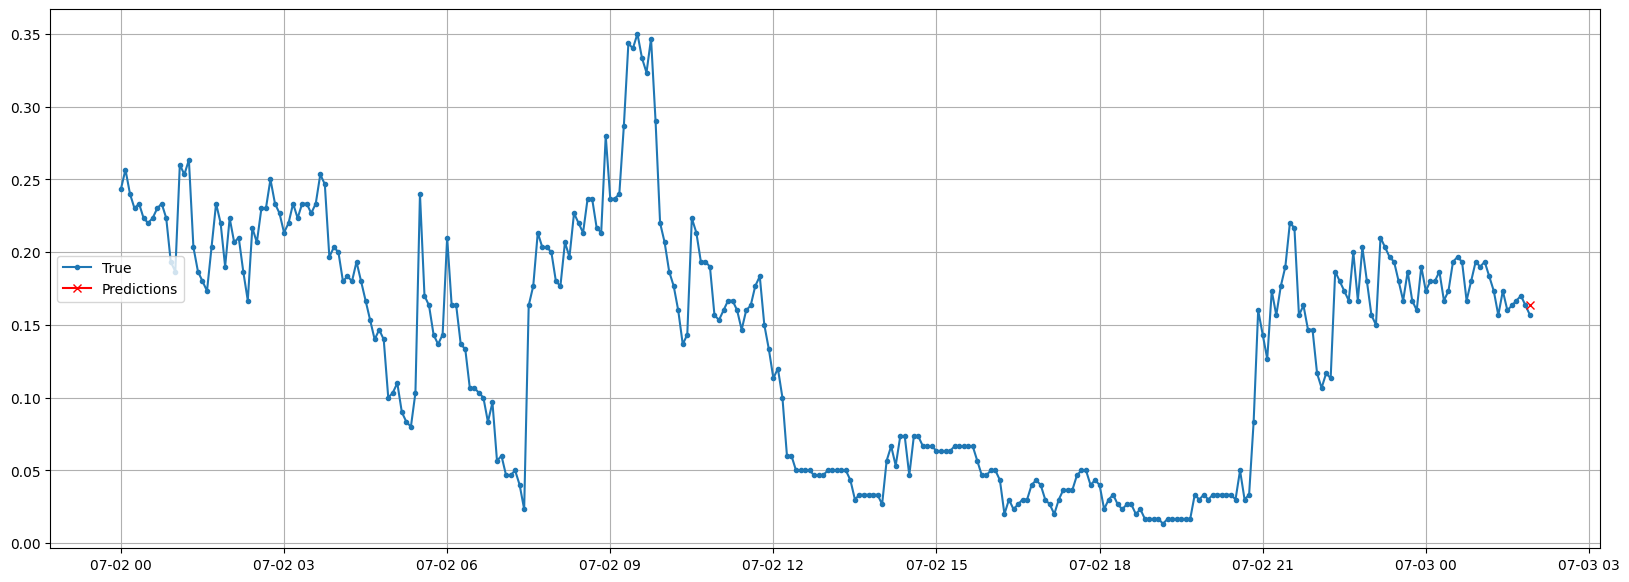

In [257]:
Y_pred = univar_model.predict(test_ds)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test.index[-1], end=test.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

#### Deep RNN

In [258]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(neurons*3, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(neurons*2, return_sequences=True),
    tf.keras.layers.SimpleRNN(neurons),
    tf.keras.layers.Dense(1)
])

In [259]:
fit_and_evaluate(deep_model, train_ds, valid_ds)

Epoch 1/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 0.0117 - mae: 0.0654 - val_loss: 9.3882e-04 - val_mae: 0.0270
Epoch 2/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.0012 - mae: 0.0265 - val_loss: 6.4970e-04 - val_mae: 0.0172
Epoch 3/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - loss: 0.0011 - mae: 0.0261 - val_loss: 6.5190e-04 - val_mae: 0.0216
Epoch 4/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0011 - mae: 0.0256 - val_loss: 6.0049e-04 - val_mae: 0.0165
Epoch 5/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0010 - mae: 0.0242 - val_loss: 5.8713e-04 - val_mae: 0.0176
Epoch 6/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0010 - mae: 0.0243 - val_loss: 6.2281e-04 - val_mae: 0.0171
Epoch 7/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0010 - mae: 0.0245 - val_loss: 7.6126e-04 - val_mae: 0.0275
Epoch 8/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0011 - mae: 0.0247 - val_loss: 8.6485e-04 - val_mae:

16469.02784705162

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


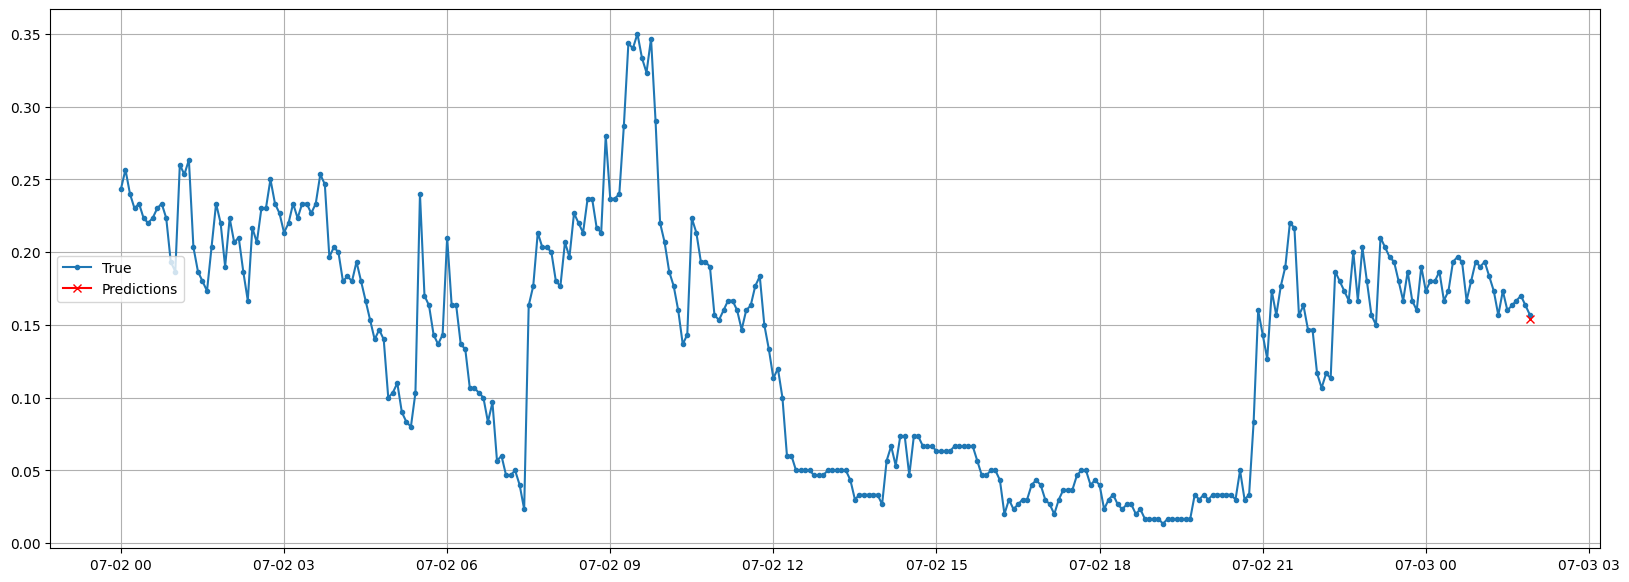

In [260]:
Y_pred = deep_model.predict(test_ds)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test.index[-1], end=test.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

### Multivariate Series

In [261]:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    train,
    targets=train['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid,
    targets=valid['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    test,
    targets=test['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Simple RNN

Notice that the only difference from the univar_model RNN we built earlier
is the input shape: at each time step, the model now receives num_features inputs instead of one.

In [262]:
mulvar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons, input_shape=[None, num_features]),
  tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [263]:
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds)

Epoch 1/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0091 - mae: 0.0736 - val_loss: 0.0011 - val_mae: 0.0250
Epoch 2/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0016 - mae: 0.0319 - val_loss: 8.5855e-04 - val_mae: 0.0228
Epoch 3/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0013 - mae: 0.0278 - val_loss: 7.5376e-04 - val_mae: 0.0194
Epoch 4/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0012 - mae: 0.0260 - val_loss: 7.0153e-04 - val_mae: 0.0181
Epoch 5/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0011 - mae: 0.0248 - val_loss: 6.8518e-04 - val_mae: 0.0184
Epoch 6/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0011 - mae: 0.0243 - val_loss: 6.8441e-04 - val_mae: 0.0201
Epoch 7/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0010 - mae: 0.0239 - val_loss: 6.8086e-04 - val_mae: 0.0204
Epoch 8/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0010 - mae: 0.0236 - val_loss: 6.4031e-04 - val_mae: 0.0167
Epoch 9

16672.657802700996

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


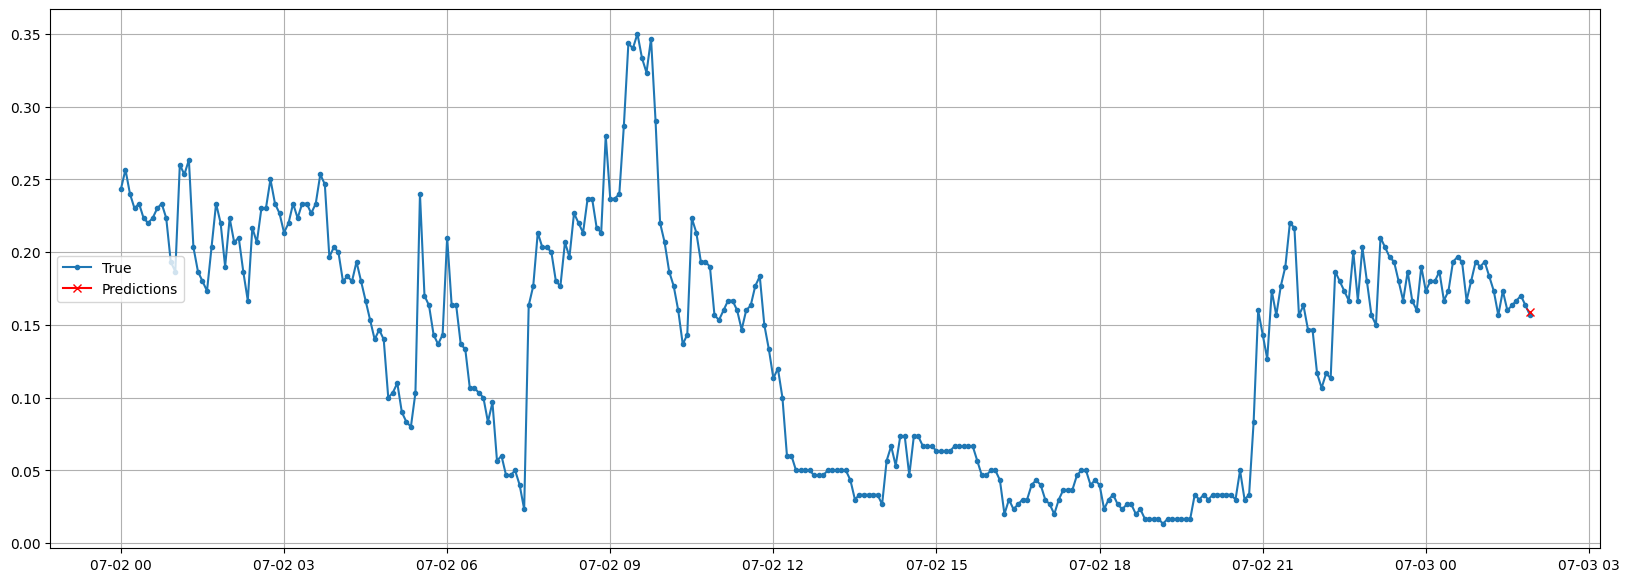

In [264]:
Y_pred = mulvar_model.predict(test_mulvar_ds)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test.index[-1], end=test.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

## Forecasting Several Time Steps Ahead

### Univariate Series

Consideriamo sempre:
* tr = train['avg_invocations_rate']
* vl = valid['avg_invocations_rate']

#### Simple RNN

The first option is to take the univar_model RNN we trained earlier for the
rail time series, make it predict the next value, and add that value to the inputs,
acting as if the predicted value had actually occurred; we would then use the
model again to predict the following value, and so on.

---
If the model makes an error at one time step, then the forecasts for the
following time steps are impacted as well: the errors tend to accumulate.
So, it’s preferable to use this technique only for a small number of steps.

 1 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
 2 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
 3 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
 4 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
 5 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
 6 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
 7 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


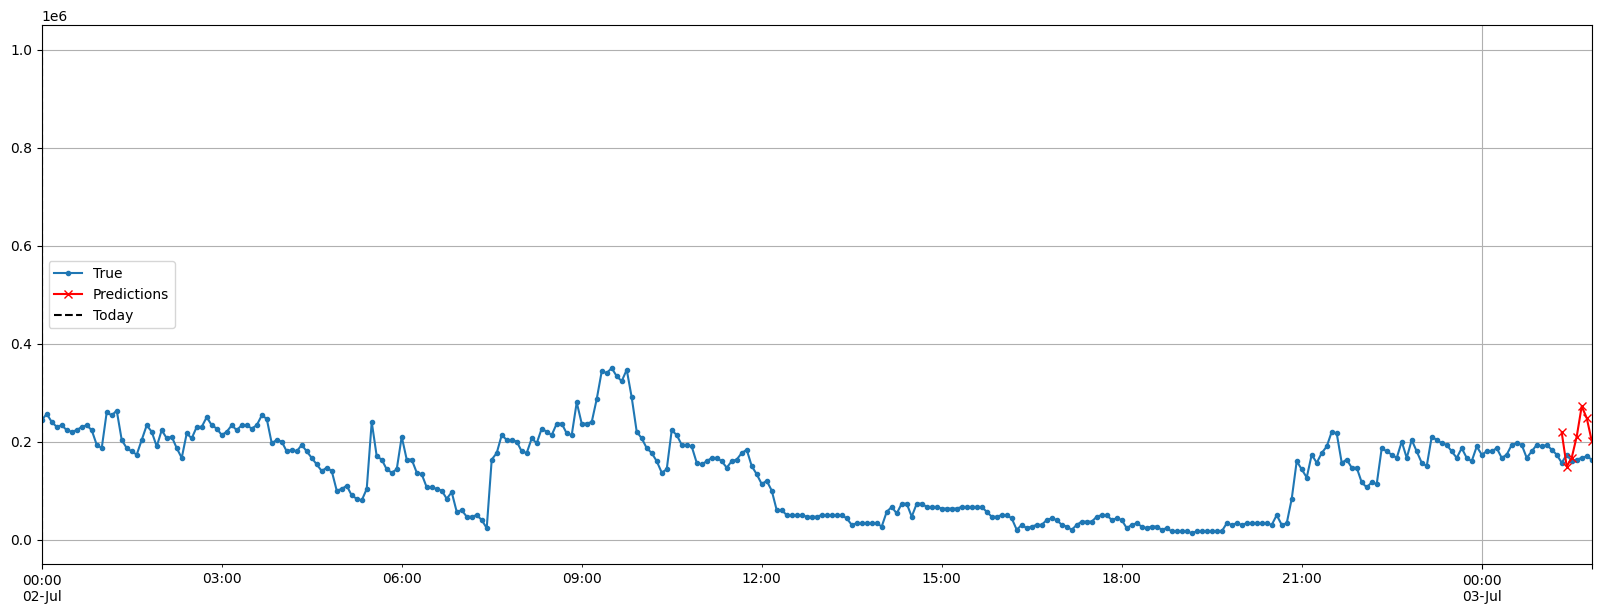

In [265]:
X = ts[:-sequence_lenght].to_numpy()[np.newaxis, :sequence_lenght, np.newaxis]
for step_ahead in range(prediction_lenght):
  print(f" {step_ahead+1} step ahead")
  y_pred_one = univar_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

Y_pred = pd.Series(X[0, -prediction_lenght:, 0], index=pd.date_range(start=ts.index[-sequence_lenght], end=ts.index[-1], freq='300s'))

fig, ax = plt.subplots(figsize=(20, 7))
(ts * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, 0, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

### Multivariate Series

In [266]:
def split_inputs_and_targets(mulvar_series, ahead=prediction_lenght, target_col=1):
  return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    train,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

ahead_test_ds = tf.keras.utils.timeseries_dataset_from_array(
    test,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

#### Sequence-to-Vector RNN

Train an RNN to predict the next 14 values in one shot.

In [267]:
ahead_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [268]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds)

Epoch 1/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.2023 - mae: 0.4372 - val_loss: 0.0637 - val_mae: 0.1942
Epoch 2/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.1458 - mae: 0.3509 - val_loss: 0.0625 - val_mae: 0.1835
Epoch 3/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.1444 - mae: 0.3468 - val_loss: 0.0645 - val_mae: 0.2152
Epoch 4/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.1426 - mae: 0.3440 - val_loss: 0.0627 - val_mae: 0.1958
Epoch 5/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.1422 - mae: 0.3428 - val_loss: 0.0618 - val_mae: 0.1737
Epoch 6/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.1416 - mae: 0.3414 - val_loss: 0.0628 - val_mae: 0.2033
Epoch 7/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.1408 - mae: 0.3404 - val_loss: 0.0612 - val_mae: 0.1801
Epoch 8/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.1398 - mae: 0.3385 - val_loss: 0.0611 - val_mae: 0.1760
Epoch 9/10
1040/1040 ━━━━━━━━━━━━━━━

173654.54137325287

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


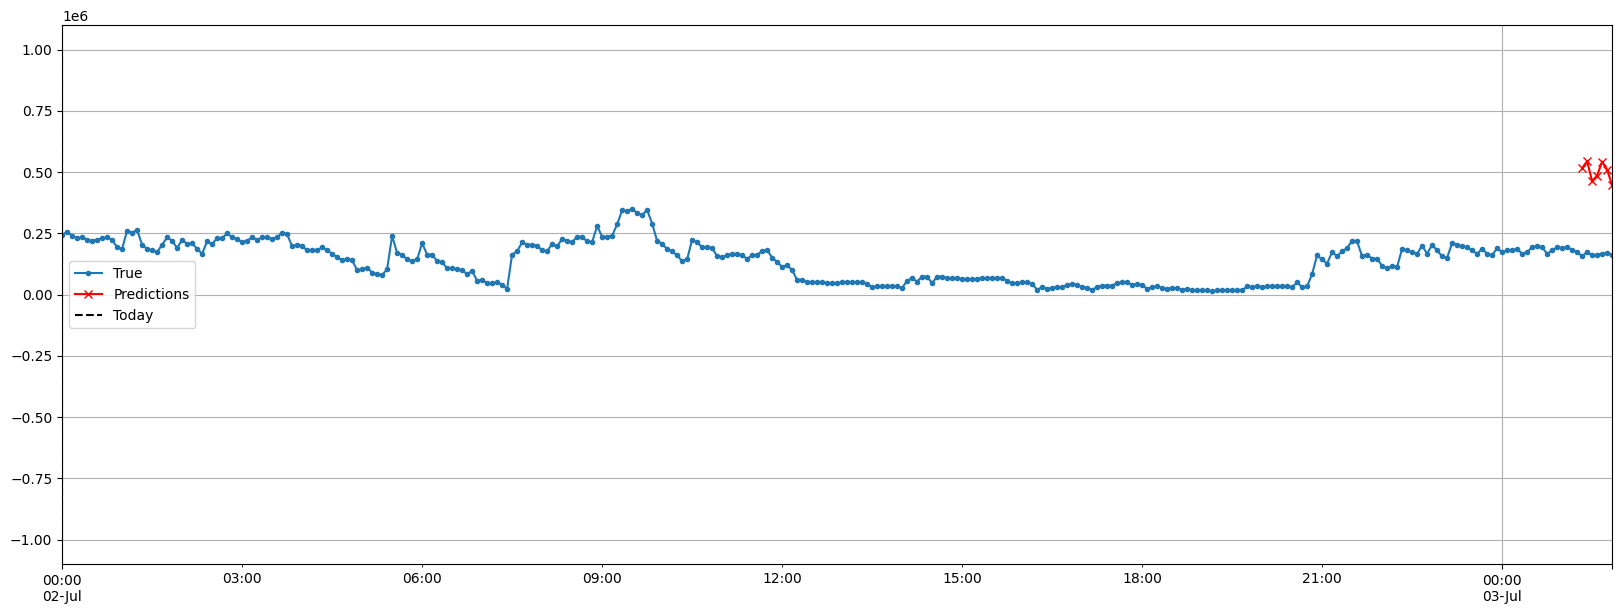

In [269]:
X = test.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = ahead_model.predict(X)
Y_pred = pd.Series(Y_pred[0], index=pd.date_range(start=ts.index[-sequence_lenght], end=ts.index[-1], freq='300s'))

fig, ax = plt.subplots(figsize=(20, 7))
(ts * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### Sequence-to-Sequence RNN

In [270]:
def to_windows(dataset, length):
  dataset = dataset.window(length, shift=1, drop_remainder=True)
  return dataset.flat_map(lambda window_ds: window_ds.batch(length))

def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1, batch_size=32, shuffle=False, seed=None):
  ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
  ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
  if shuffle:
    ds = ds.shuffle(8 * batch_size, seed=seed)
  return ds.batch(batch_size)

In [271]:
seq2seq_train = to_seq2seq_dataset(train, seq_length=sequence_lenght, ahead=prediction_lenght, shuffle=True, seed=seed)
seq2seq_valid = to_seq2seq_dataset(valid, seq_length=sequence_lenght, ahead=prediction_lenght)
seq2seq_test = to_seq2seq_dataset(test, seq_length=sequence_lenght, ahead=prediction_lenght)

Instead of training the model to forecast the next 14 values only at the very last time step, we can train it to forecast the next 14 values at each and every time step.
In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN.

* The targets are sequences of consecutive windows, shifted by one time step at each time step;
* The target is not a vector anymore, but a sequence of the same length as the inputs, containing a (prediction_lenght)-dimensional vector at each step.

It is almost identical to our previous model: the only difference is that we set
return_sequences=True in the SimpleRNN layer. This way, it will
output a sequence of vectors (each of size 'batch_size'), instead of outputting a single
vector at the last time step. The Dense layer is smart enough to handle
sequences as input: it will be applied at each time step, taking a 'batch_size'-dimensional
vector as input and outputting a 'prediction_lenght'-dimensional vector.

In [272]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(neurons, return_sequences=True, input_shape=[None, num_features]),
    tf.keras.layers.Dense(prediction_lenght)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [273]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid)

Epoch 1/10
   1036/Unknown 13s 11ms/step - loss: 0.1870 - mae: 0.4296

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1040/1040 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.1869 - mae: 0.4295 - val_loss: 0.0653 - val_mae: 0.2011
Epoch 2/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.1386 - mae: 0.3475 - val_loss: 0.0644 - val_mae: 0.2034
Epoch 3/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.1333 - mae: 0.3373 - val_loss: 0.0647 - val_mae: 0.2116
Epoch 4/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.1320 - mae: 0.3349 - val_loss: 0.0652 - val_mae: 0.2203
Epoch 5/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.1312 - mae: 0.3338 - val_loss: 0.0651 - val_mae: 0.2208
Epoch 6/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.1308 - mae: 0.3329 - val_loss: 0.0644 - val_mae: 0.2172
Epoch 7/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.1301 - mae: 0.3315 - val_loss: 0.0630 - val_mae: 0.2029
Epoch 8/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.1296 - mae: 0.3304 - val_loss: 0.0637 - val_mae: 0.2124
Epoch 9/10
1040/1040 ━━━━━━━━━━━━━━

199733.97254943848

Perchè sembra migliorare? dovrebbe peggiorare (?)

In [274]:
Y_pred_valid = seq2seq_model.predict(seq2seq_test)
for ahead in range(prediction_lenght):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=test.index[sequence_lenght + ahead : -prediction_lenght + ahead])
    mae = (preds - test["avg_invocations_rate"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE for +1: 296,678
MAE for +2: 305,973
MAE for +3: 306,937
MAE for +4: 282,372
MAE for +5: 261,735
MAE for +6: 303,051
MAE for +7: 252,541


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


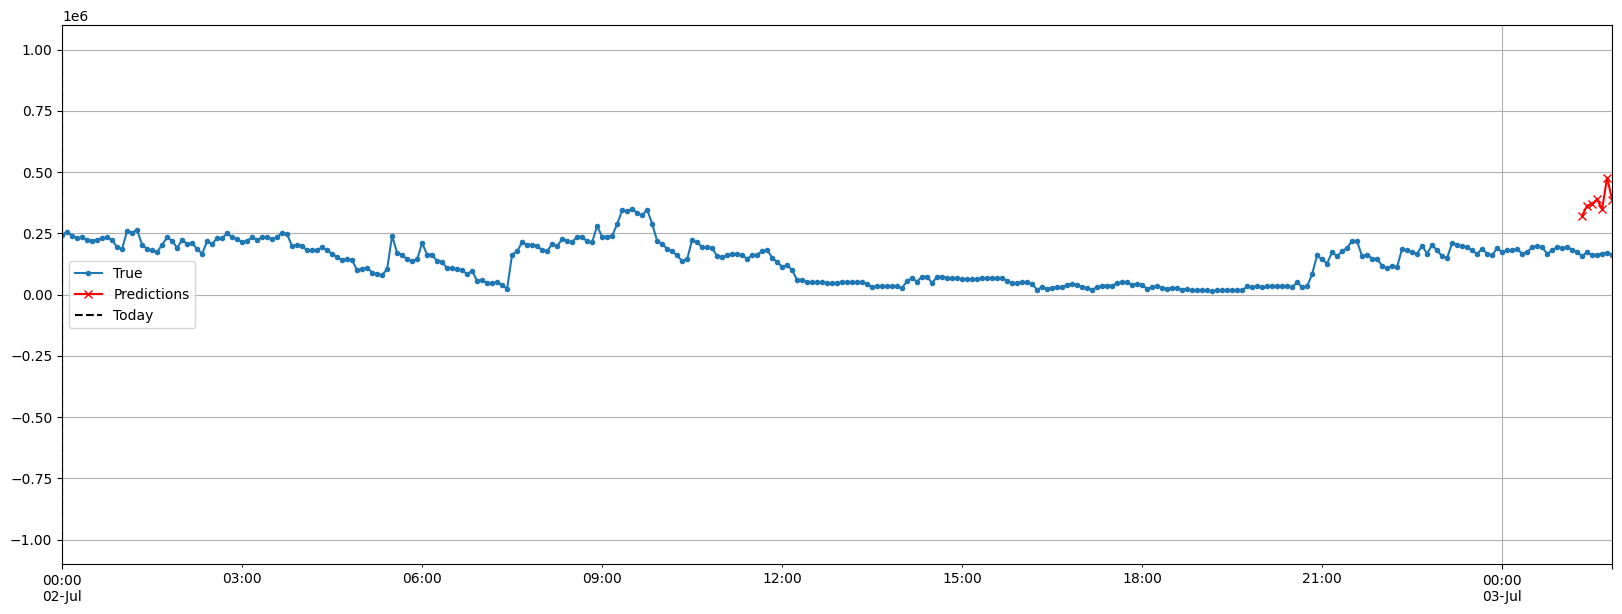

In [275]:
X = test.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts.index[-sequence_lenght], end=ts.index[-1], freq='300s'))

fig, ax = plt.subplots(figsize=(20, 7))
(ts * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### RNN with layer normalization

In [276]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [277]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(neurons), return_sequences=True, input_shape=[None, num_features]),
    tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [278]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid)

Epoch 1/10
   1034/Unknown 21s 14ms/step - loss: 0.1969 - mae: 0.4485

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1040/1040 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - loss: 0.1968 - mae: 0.4482 - val_loss: 0.0680 - val_mae: 0.2369
Epoch 2/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.1403 - mae: 0.3540 - val_loss: 0.0669 - val_mae: 0.2342
Epoch 3/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.1355 - mae: 0.3442 - val_loss: 0.0673 - val_mae: 0.2406
Epoch 4/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.1325 - mae: 0.3386 - val_loss: 0.0680 - val_mae: 0.2448
Epoch 5/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.1312 - mae: 0.3362 - val_loss: 0.0666 - val_mae: 0.2365
Epoch 6/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.1304 - mae: 0.3346 - val_loss: 0.0680 - val_mae: 0.2465
Epoch 7/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - loss: 0.1302 - mae: 0.3334 - val_loss: 0.0683 - val_mae: 0.2482
Epoch 8/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 0.1297 - mae: 0.3332 - val_loss: 0.0668 - val_mae: 0.2401
Epoch 9/10
1040/1040 ━━━━━━━━━━━━━━

234170.43685913086

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


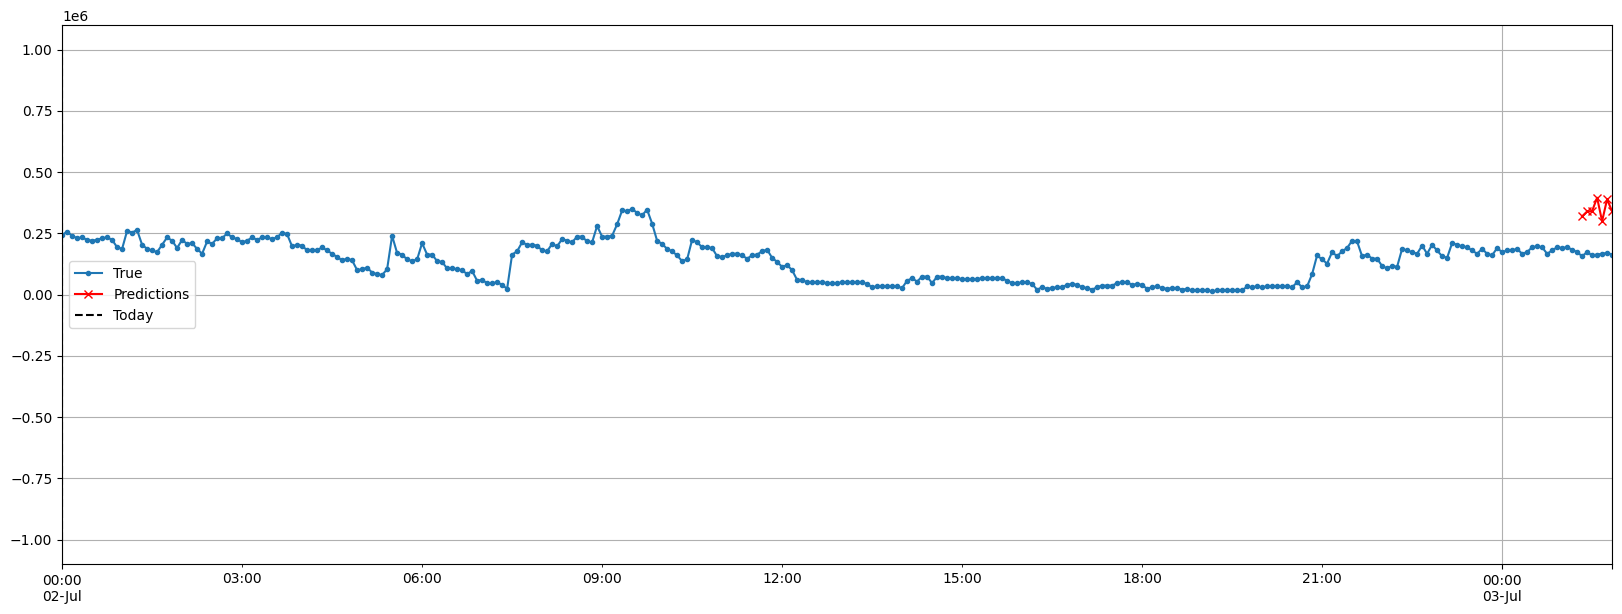

In [279]:
X = test.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = custom_ln_model.predict(X)  # but then [0, -1] because only the last time step's output

Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts.index[-sequence_lenght], end=ts.index[-1], freq='300s'))

fig, ax = plt.subplots(figsize=(20, 7))
(ts * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

 #### LSTM

In [280]:
lstm = tf.keras.Sequential([
  tf.keras.layers.LSTM(neurons, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [281]:
fit_and_evaluate(lstm, seq2seq_train, seq2seq_valid)

Epoch 1/10
   1032/Unknown 15s 13ms/step - loss: 0.2308 - mae: 0.4976

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1040/1040 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.2304 - mae: 0.4969 - val_loss: 0.0666 - val_mae: 0.2206
Epoch 2/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.1435 - mae: 0.3553 - val_loss: 0.0654 - val_mae: 0.2172
Epoch 3/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.1381 - mae: 0.3453 - val_loss: 0.0649 - val_mae: 0.2178
Epoch 4/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.1352 - mae: 0.3409 - val_loss: 0.0647 - val_mae: 0.2176
Epoch 5/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.1336 - mae: 0.3386 - val_loss: 0.0645 - val_mae: 0.2189
Epoch 6/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.1320 - mae: 0.3361 - val_loss: 0.0642 - val_mae: 0.2180
Epoch 7/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.1314 - mae: 0.3352 - val_loss: 0.0641 - val_mae: 0.2179
Epoch 8/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.1309 - mae: 0.3348 - val_loss: 0.0640 - val_mae: 0.2179
Epoch 9/10
1040/1040 ━━━━━━━━━━━━━━

215567.88682937622

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


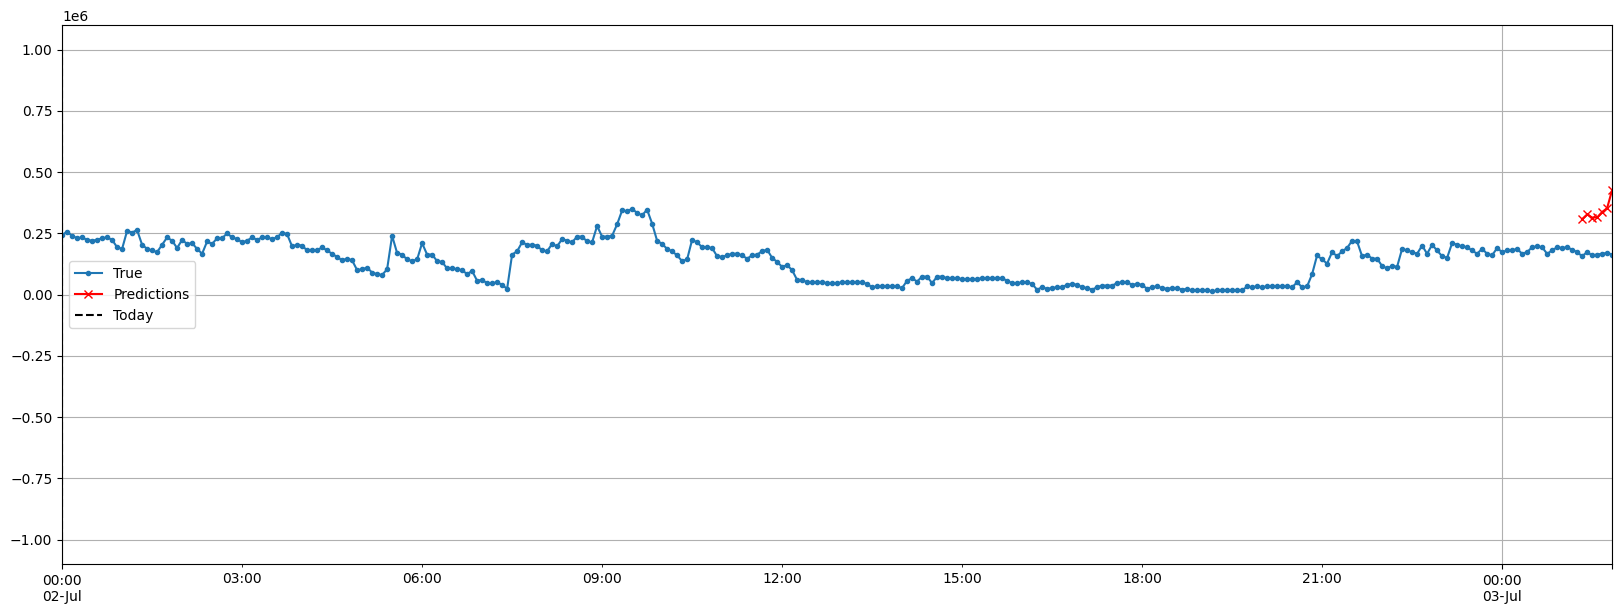

In [282]:
X = test.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = lstm.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts.index[-sequence_lenght], end=ts.index[-1], freq='300s'))

fig, ax = plt.subplots(figsize=(20, 7))
(ts * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### GRU

The GRU cell is a simplified version of the LSTM cell...

In [283]:
gru = tf.keras.Sequential([
  tf.keras.layers.GRU(neurons, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [284]:
fit_and_evaluate(gru, seq2seq_train, seq2seq_valid)

Epoch 1/10
   1038/Unknown 15s 13ms/step - loss: 0.1990 - mae: 0.4448

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1040/1040 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 0.1989 - mae: 0.4447 - val_loss: 0.0656 - val_mae: 0.2130
Epoch 2/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 0.1410 - mae: 0.3512 - val_loss: 0.0650 - val_mae: 0.2117
Epoch 3/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.1389 - mae: 0.3460 - val_loss: 0.0646 - val_mae: 0.2103
Epoch 4/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.1379 - mae: 0.3437 - val_loss: 0.0643 - val_mae: 0.2095
Epoch 5/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.1367 - mae: 0.3416 - val_loss: 0.0638 - val_mae: 0.2086
Epoch 6/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 0.1359 - mae: 0.3401 - val_loss: 0.0638 - val_mae: 0.2100
Epoch 7/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 0.1342 - mae: 0.3377 - val_loss: 0.0629 - val_mae: 0.2059
Epoch 8/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.1332 - mae: 0.3360 - val_loss: 0.0632 - val_mae: 0.2114
Epoch 9/10
1040/1040 ━━━━━━━━━━━━━━

205919.7872877121

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


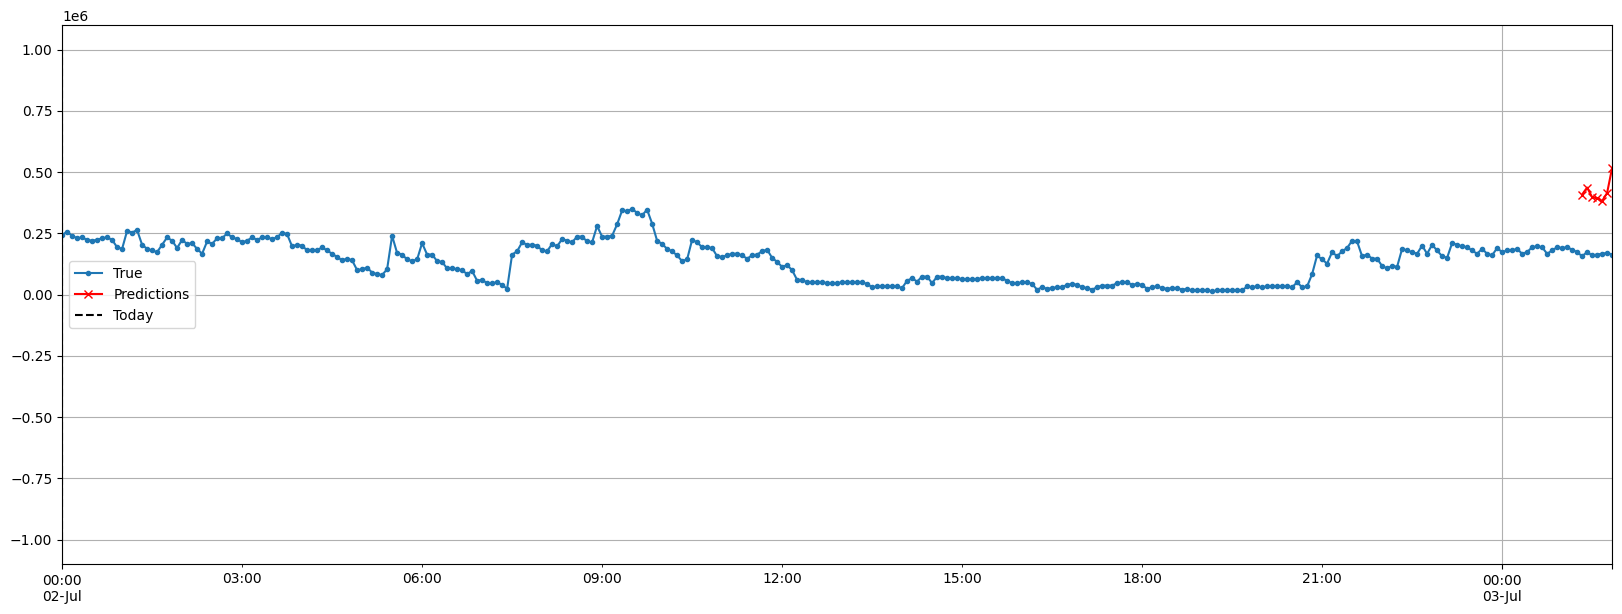

In [285]:
X = test.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = gru.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts.index[-sequence_lenght], end=ts.index[-1], freq='300s'))

fig, ax = plt.subplots(figsize=(20, 7))
(ts * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### CNN

In [286]:
seq2seq_cnn_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons*2, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Conv1D(prediction_lenght, kernel_size=1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [287]:
fit_and_evaluate(seq2seq_cnn_model, seq2seq_train, seq2seq_valid)

Epoch 1/10
   1040/Unknown 12s 11ms/step - loss: 0.1777 - mae: 0.4112

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1040/1040 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.1777 - mae: 0.4112 - val_loss: 0.0654 - val_mae: 0.2094
Epoch 2/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.1391 - mae: 0.3452 - val_loss: 0.0636 - val_mae: 0.2003
Epoch 3/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.1354 - mae: 0.3389 - val_loss: 0.0633 - val_mae: 0.2018
Epoch 4/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.1333 - mae: 0.3358 - val_loss: 0.0626 - val_mae: 0.1958
Epoch 5/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.1316 - mae: 0.3332 - val_loss: 0.0630 - val_mae: 0.2050
Epoch 6/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.1305 - mae: 0.3317 - val_loss: 0.0623 - val_mae: 0.1892
Epoch 7/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.1299 - mae: 0.3298 - val_loss: 0.0629 - val_mae: 0.2056
Epoch 8/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.1287 - mae: 0.3285 - val_loss: 0.0622 - val_mae: 0.1968
Epoch 9/10
1040/1040 ━━━━━━━━━━━━━━

189150.24399757385

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


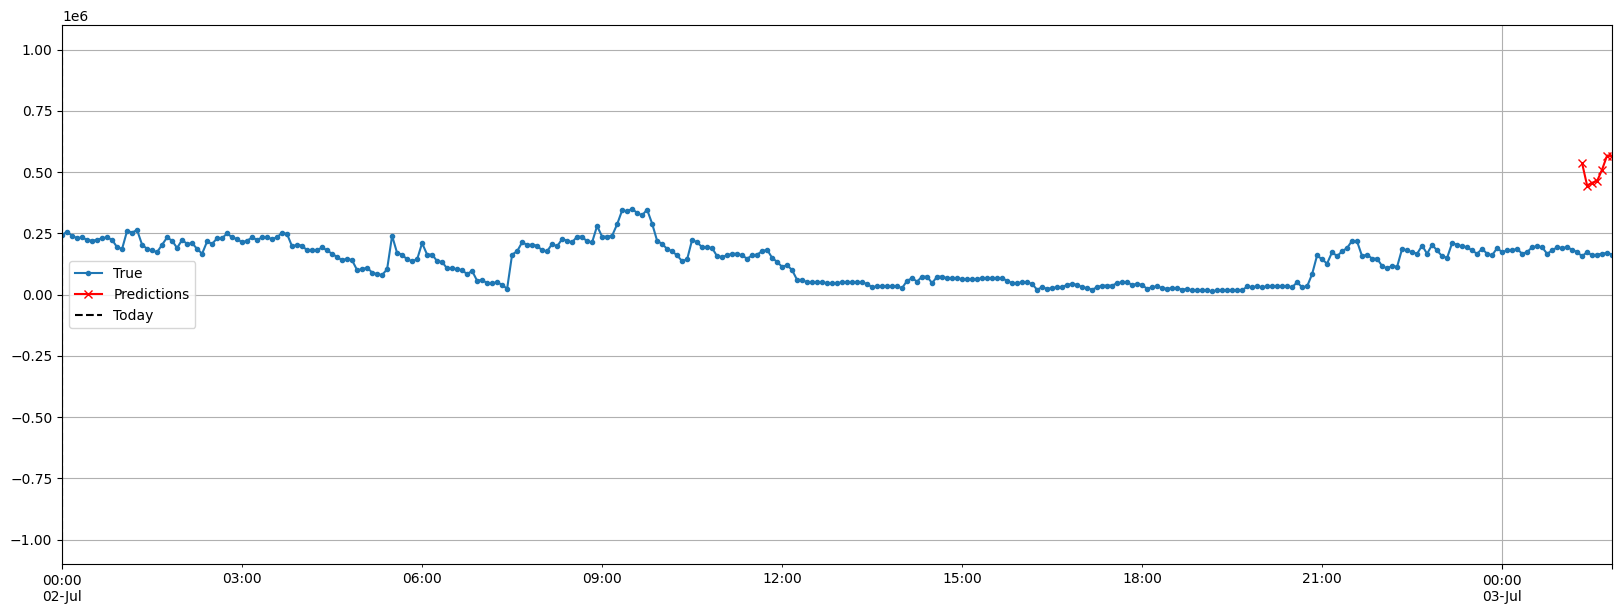

In [288]:
X = test.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_cnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts.index[-sequence_lenght], end=ts.index[-1], freq='300s'))

fig, ax = plt.subplots(figsize=(20, 7))
(ts * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

LSTM and GRU cells are one of the main reasons behind the success of RNNs.
Yet while they can tackle much longer sequences than simple RNNs, they still
have a fairly limited short-term memory, and they have a hard time learning
long-term patterns in sequences of 100 time steps or more, such as audio
samples, long time series, or long sentences. One way to solve this is to shorten
the input sequences; for example, using 1D convolutional layers.

In [289]:
stride = 2
k_size = 4

conv_rnn_model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=k_size, strides=stride, activation="relu", input_shape=[None, num_features]),
  tf.keras.layers.GRU(batch_size, return_sequences=True),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [290]:
longer_train = to_seq2seq_dataset(train, seq_length=sequence_lenght*2, shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(valid, seq_length=sequence_lenght*2)
longer_test = to_seq2seq_dataset(test, seq_length=sequence_lenght*2)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_test = longer_test.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))

In [291]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid)

Epoch 1/10
   1034/Unknown 17s 14ms/step - loss: 0.1799 - mae: 0.4153

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1040/1040 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.1798 - mae: 0.4151 - val_loss: 0.0654 - val_mae: 0.2208
Epoch 2/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 0.1296 - mae: 0.3325 - val_loss: 0.0640 - val_mae: 0.2178
Epoch 3/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: 0.1271 - mae: 0.3270 - val_loss: 0.0628 - val_mae: 0.2067
Epoch 4/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.1259 - mae: 0.3239 - val_loss: 0.0623 - val_mae: 0.2034
Epoch 5/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.1252 - mae: 0.3226 - val_loss: 0.0624 - val_mae: 0.2070
Epoch 6/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - loss: 0.1247 - mae: 0.3212 - val_loss: 0.0622 - val_mae: 0.2039
Epoch 7/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.1244 - mae: 0.3207 - val_loss: 0.0622 - val_mae: 0.2029
Epoch 8/10
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 0.1238 - mae: 0.3189 - val_loss: 0.0622 - val_mae: 0.2050
Epoch 9/10
1040/1040 ━━━━━━━━━━━━━━

200771.60000801086

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


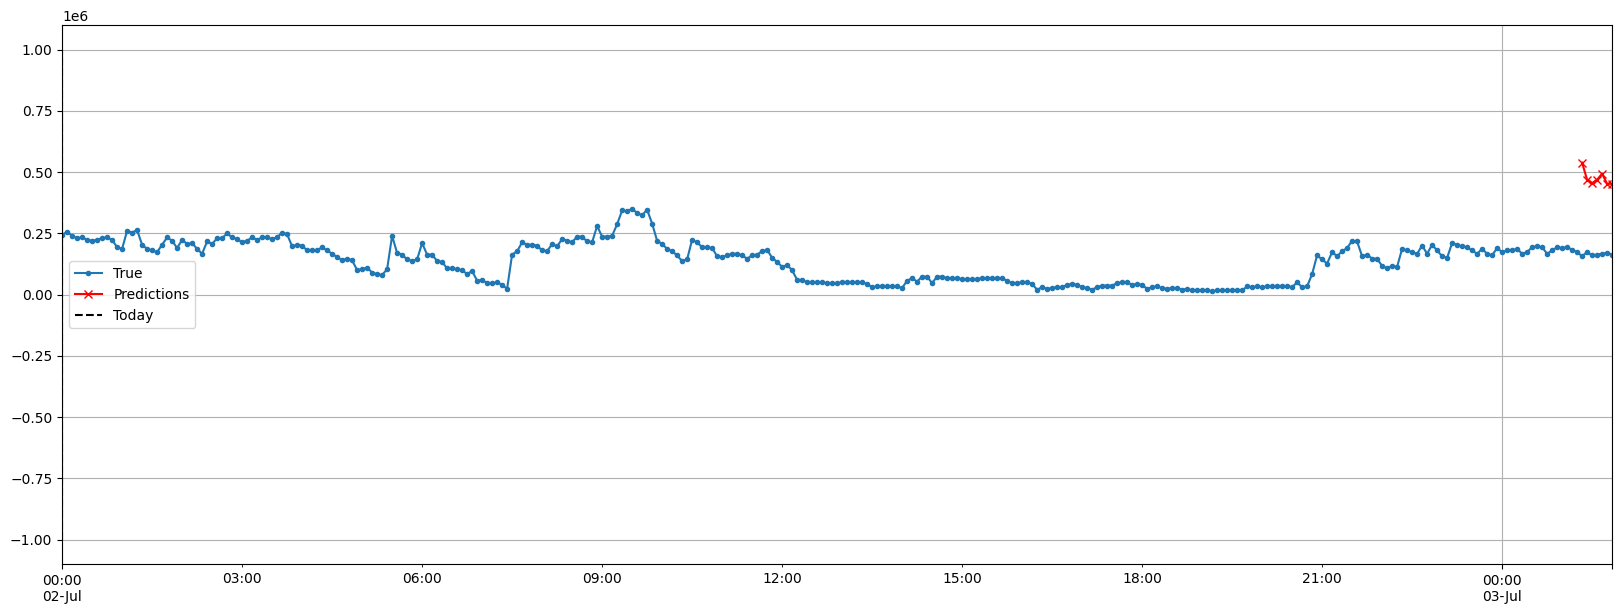

In [292]:
X = test.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = conv_rnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts.index[-sequence_lenght], end=ts.index[-1], freq='300s'))

fig, ax = plt.subplots(figsize=(20, 7))
(ts * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

## ARMA family



In [293]:
from statsmodels.tsa.arima.model import ARIMA

Check for stationarity with the Augmented Dickey-Fuller test

In [294]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train['avg_invocations_rate'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -14.265884059970611
p-value: 1.4008921886672815e-26


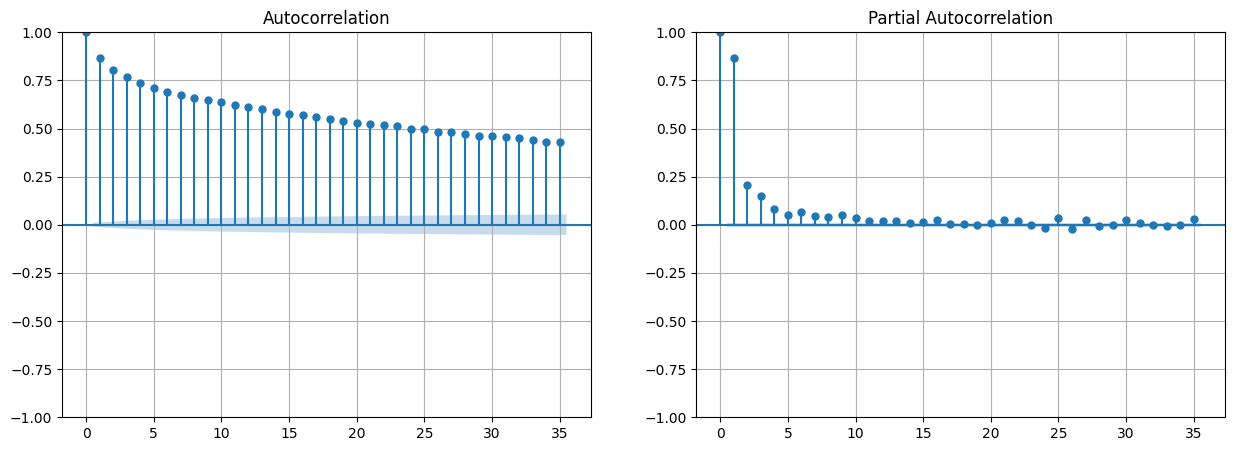

In [295]:
# extra code – shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(train['avg_invocations_rate'], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(train['avg_invocations_rate'], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

order=(p, d, q):
* p = the past p values of the time series, "how far back into the past the model should look";
* d = *order of integration*, running d consecutive rounds of differencing computes an approximation of the dth order derivative of the time series, so it will eliminate polynomial trends up to degree d.
* q = the past q forecast errors ε(t);

seasonal_order=(P, D, Q, s)
* P = , D = , Q =  : to model the time series at  (t–s), (t–2s), (t–3s);
* s = the period of the seasonal pattern.


In [296]:
trimmed_valid = ts.iloc[:-prediction_lenght]
# in realtà dal test risulta stazionaria, ma le performance sembrano migliori
arima = ARIMA(trimmed_valid, order=(1,1,1))
arima = arima.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


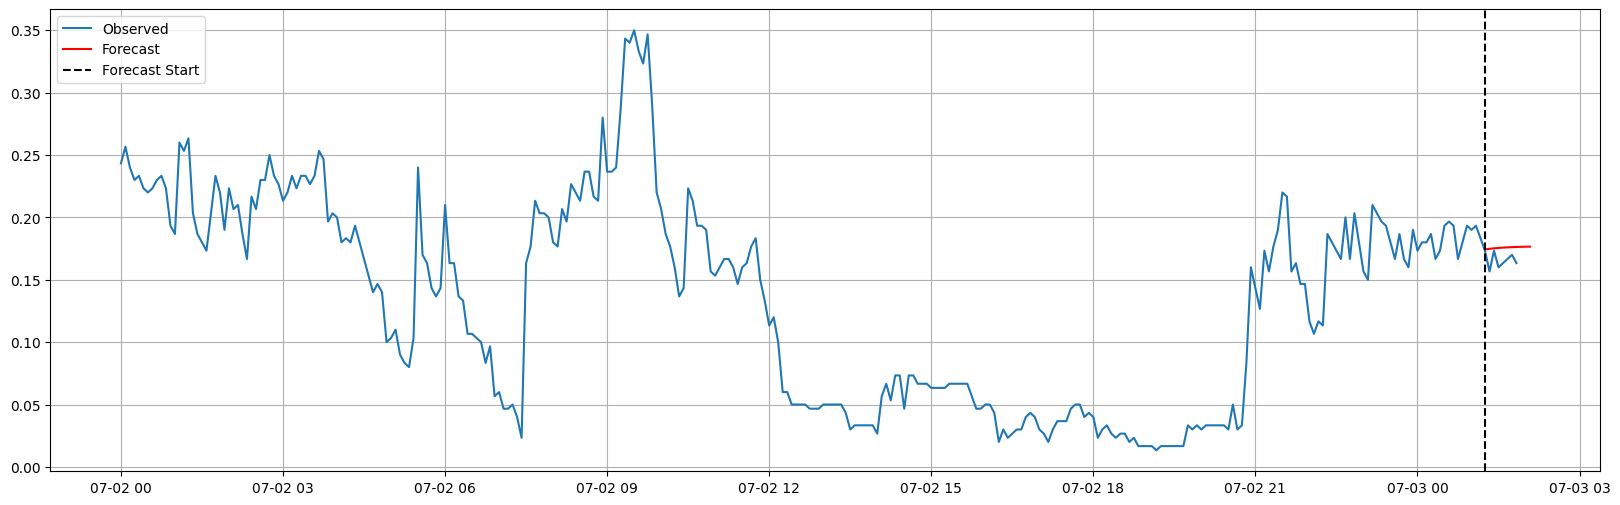

In [297]:
# Forecasting
forecast = arima.forecast(steps=prediction_lenght)

plt.figure(figsize=(20, 6))
# Plot the forecast
# original data: full length
plt.plot(ts.index, ts, label='Observed')
plt.plot(pd.date_range(trimmed_valid.index[-1], periods=prediction_lenght, freq='500s'), forecast, label='Forecast', color='red')
plt.axvline(trimmed_valid.index[-1], linestyle='--', color='black', label='Forecast Start')
plt.legend()
plt.grid()
plt.show()

In [298]:
print(forecast)

2023-07-03 01:20:00    0.174373
2023-07-03 01:25:00    0.175109
2023-07-03 01:30:00    0.175630
2023-07-03 01:35:00    0.175999
2023-07-03 01:40:00    0.176260
2023-07-03 01:45:00    0.176445
2023-07-03 01:50:00    0.176575
Freq: 5min, Name: predicted_mean, dtype: float64
